In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
import torch.utils.data as data
import zuko


In [2]:
def kernel(qs, thetas):
    """
    qs: which is a matrix of size (m, 1)
    thetas: which is a matrix of size (n, 1)
    """
    return np.exp( - np.outer(qs, thetas) ) 

def Cartesian(thetas):
    weights = np.gradient(thetas)
    return weights

def forward_operator(qs, thetas):
    weights = Cartesian(thetas)
    weights_matrix = np.tile(weights.flatten(order='F'), (qs.shape[0], 1))
    return kernel(qs, thetas) * weights_matrix

def forward_model(qs, thetas, f_thetas):
    return forward_operator(qs, thetas) @ f_thetas

def f_given_parameters(thetas, parameters, modes, sample_size = 1000):
    if len(parameters) != modes * 3:
        raise ValueError("Parameters should be of length modes * 3")
    means = parameters[:modes]
    sigmas = parameters[modes:2*modes]
    weights = parameters[2*modes:]

    f_thetas = np.zeros_like(thetas)

    for i in range(modes):
        f_thetas += weights[i] * norm.pdf(thetas, loc=means[i], scale=sigmas[i])
    
    components = np.random.choice(modes, size=sample_size, p=weights)
    samples = np.random.normal(loc=means[components], scale=sigmas[components])

    return f_thetas, samples

def synthetic_f(thetas, modes = 1, sample_size = 1000):

    f_thetas = np.zeros_like(thetas)

    mean = np.empty(modes)
    sigma = np.empty(modes)
    weights = np.random.dirichlet([1]* modes)

    for i in range(modes):
        while True:
            mean[i] = np.random.uniform(np.min(thetas), np.max(thetas))
            sigma[i] = np.random.uniform(0.05, np.max(thetas)/6)
            if mean[i] - 3 * sigma[i] >= np.min(thetas) and mean[i] + 3 * sigma[i] <= np.max(thetas):
                break
            
    idx = np.argsort(mean) # always sort means and reorder sigmas and weights accordingly
    mean = mean[idx]
    sigma = sigma[idx]
    weights = weights[idx]

    parameters = np.concatenate([mean, sigma, weights])
    f_thetas, samples = f_given_parameters(thetas, parameters, modes, sample_size)

    return f_thetas, parameters, samples

def synthetic_Sqs(qs, thetas, f_thetas):
    Sqs = forward_operator(qs, thetas) @ f_thetas
    return Sqs
    

### Training Data

In [8]:
thetas = np.linspace(0, 6, 60)
qs = np.linspace(0, 3.5, 10)

number = 512
sample_size = 200

Sqs = np.empty((number, qs.shape[0]))
f_thetas = np.empty((number, thetas.shape[0]))
samples = np.empty((number, sample_size))

for i in range(number):
    f_thetas[i,:], _, samples[i,:] = synthetic_f(thetas, modes=np.random.choice([1, 2, 3]), sample_size=sample_size)
    Sqs[i, :] = synthetic_Sqs(qs, thetas, f_thetas[i,:])


Sqs_torch = torch.tensor(np.repeat(Sqs, sample_size, axis=0), dtype=torch.float32)
samples_torch = torch.tensor(samples.reshape(-1, 1, order = 'C'), dtype=torch.float32)

trainset = data.TensorDataset(samples_torch, Sqs_torch)
trainloader = data.DataLoader(trainset, batch_size = 64, shuffle=True)

### Model

In [9]:
flow = zuko.flows.MAF(features= 1 , context = 10, transforms=4, hidden_features=[128, 128])
optimizer = Adam(flow.parameters(), lr=1e-3)

for epoch in range(10):

    for samples_batch, Sqs_batch in trainloader:
        dist = flow(Sqs_batch)
        loss = - dist.log_prob(samples_batch).mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if (epoch+1) % 1 == 0:
        print(f"Finished: {epoch+1}, L2 Loss: {loss.item():.6f}")


Finished: 1, L2 Loss: 0.915513
Finished: 2, L2 Loss: 0.828228
Finished: 3, L2 Loss: 0.788292
Finished: 4, L2 Loss: 0.984907
Finished: 5, L2 Loss: 0.889409
Finished: 6, L2 Loss: 0.868917
Finished: 7, L2 Loss: 0.670588
Finished: 8, L2 Loss: 0.719382
Finished: 9, L2 Loss: 0.867834
Finished: 10, L2 Loss: 0.821907


### Test

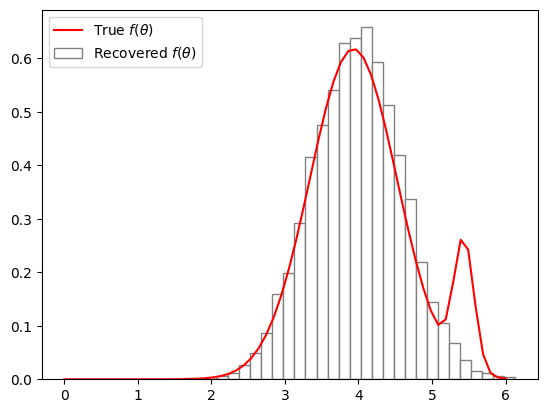

In [44]:
f_thetas_test, _, _ = synthetic_f(thetas, modes=np.random.choice([1, 2, 3]))
Sqs_test = synthetic_Sqs(qs, thetas, f_thetas_test)

import torch
import matplotlib.pyplot as plt

# Prepare test input
Sqs_test_torch = torch.tensor(Sqs_test, dtype=torch.float32).unsqueeze(0)  # shape: (1, 5)

# Sample predicted results from the trained flow
flow.eval()
with torch.no_grad():
    dist = flow(Sqs_test_torch)                   
    samples = dist.rsample((10000,)).squeeze().numpy()
# plot the truth
plt.plot(thetas, f_thetas_test, linestyle='-', color = 'red', label="True $f(\\theta)$")

# Plot the prediction
# plt.plot(thetas, f_mean.numpy().flatten(), label="Prediction")
plt.hist(samples, density = 1, bins=30, edgecolor='grey', color = 'white', label="Recovered $f(\\theta)$")

plt.legend()
